In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
from tqdm import tqdm, trange
import cv2
import numba as nb
from ast import literal_eval
from collections import defaultdict, Counter
import copy
plt.style.use('seaborn-whitegrid')



# Functions to map between cartesian coordinates and array indexes
@nb.njit
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j

@nb.njit
def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)


def imread(path):
    if isinstance(path, Path):
        path = path.as_posix()
    return cv2.imread(path)[:, :, ::-1] / 255


@nb.njit
def get_position(config):
    return config.sum(0)

@nb.njit
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)

@nb.njit
def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


# compress a path between two points
@nb.njit
def compress_path(path):
    n_joints = path.shape[1]
    r = np.zeros((n_joints, path.shape[0], 2), dtype=path.dtype)
    l = np.zeros(n_joints, dtype='int')
    for j in range(len(path)):
        for i in range(n_joints):
            if l[i] == 0 or (r[i][l[i] - 1] != path[j, i]).any():
                r[i, l[i]] = path[j, i]
                l[i] += 1
    r = r[:, :l.max()]

    for i in range(n_joints):
        for j in range(l[i], r.shape[1]):
            r[i, j] = r[i, j - 1]
    r = r.transpose(1, 0, 2)

    return r


@nb.njit
def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    # direction = np.sign(np.cross(u, v))
    direction = np.sign(u[0] * v[1] - u[1] * v[0])
    if direction == 0 and (u * v).sum() < 0:
        direction = 1
    return direction


@nb.njit
def get_radius(config):
    r = 0
    for link in config:
        r += np.abs(link).max()
    return r

@nb.njit
def get_radii(config):
    radii = np.cumsum(np.maximum(np.abs(config[:, 0]), np.abs(config[:, 1]))[::-1])[::-1]
    return np.append(radii, np.zeros(1, dtype='int'))


@nb.njit
def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    config_start = config.copy()
    radii = get_radii(config)

    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = point - base
        position = get_position(config[:i+1])
        relpos = point - position
        radius = radii[i + 1]
        # Special case when next-to-last link lands on point. 
        if radius == 1 and (relpos == 0).all():
            config = rotate(config, i, 1)
            if (get_position(config) == point).all():
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            link = config[i]
            base = get_position(config[:i])
            relbase = point - base
            position = get_position(config[:i+1])
            relpos = point - position
            radius = get_radius(config[i + 1:])

    assert (get_position(config) == point).all()
    path = get_path_to_configuration(config_start, config)

    return path


@nb.njit
def get_path_to_configuration(from_config, to_config):
    path = np.expand_dims(from_config, 0).copy()
    config = from_config.copy()
    while (config != to_config).any():
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path = np.append(path, np.expand_dims(config, 0), 0)
    assert (path[-1] == to_config).all()
    return path


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
@nb.njit
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    #if not (diffs <= 1).all():
# #         print(f'illegal movement by {diffs} from {from_config.sum(axis=0)} to {to_config.sum(axis=0)}')
# #         print(from_config)
# #         print(to_config)
        #bad_cost = np.double(1e6)
        #return bad_cost
#     assert diffs.sum() >= 1 # the configurations should not be equal
    #assert (diffs <= 1).all(), (diffs, from_config, to_config)
    #assert diffs.max() <= 1
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
@nb.njit
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
@nb.njit
def step_cost(from_config, to_config, image):
    pos_from = get_position(from_config)
    pos_to = get_position(to_config)
    from_position = cartesian_to_array(pos_from[0], pos_from[1], image.shape)
    to_position = cartesian_to_array(pos_to[0], pos_to[1], image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

# Compute total cost of path over image
@nb.njit
def total_cost(path, image):
    cost = 0
    for i in range(1, len(path)):
        cost += step_cost(path[i - 1], path[i], image)
    return cost


def get_origin(size):
    assert size % 2 == 1
    radius = size // 2
    p = [1]
    for power in range(0, 8):
        p.append(2**power)
        if sum(p) == radius:
            break
    else:
        assert False
    p = p[::-1]
    config = np.array([(p[0], 0)] + [(-pp, 0) for pp in p[1:]])
    return config

def standard_config_topright(x, y):
    """Return the preferred configuration (list of eight pairs) for the point (x,y)"""
    assert x >= 0 and y > 0, "This function is only for the upper right quadrant"
    r = 64
    config = [(r, y-r)] # longest arm points to the right
    x = x - config[0][0]
    while r > 1:
        r = r // 2
        arm_x = np.clip(x, -r, r)
        config.append((arm_x, r)) # arm points upwards
        x -= arm_x
    arm_x = np.clip(x, -r, r)
    config.append((arm_x, r)) # arm points upwards
    assert x == arm_x
    return np.array(config)


def standard_config_topleft(x, y):
    """Return the preferred configuration (list of eight pairs) for the point (x,y)"""
    assert x < 0 and y >= 0, "This function is only for the upper left quadrant"
    r = 64
    config = [(x+r, r)] # longest arm points up
    y = y - config[0][1]
    while r > 1:
        r = r // 2
        arm_y = np.clip(y, -r, r)
        config.append((-r,arm_y)) # arm points left
        y -= arm_y
    arm_y = np.clip(y, -r, r)
    config.append((-r,   arm_y)) # arm points left
    assert y  == arm_y
    return np.array(config)


def standard_config_botright(x, y):
    """Return the preferred configuration (list of eight pairs) for the point (x,y)"""
    assert x >= 0 and y <= 0, "This function is only for the bottom right quadrant"
    r = 64
    config = [(x-r, -r)] # longest arm points down
    y = y - config[0][1]
    while r > 1:
        r = r // 2
        arm_y = np.clip(y, -r, r)
        config.append((r,arm_y)) # arm points right
        y -= arm_y
    arm_y = np.clip(y, -r, r)
    config.append((r,   arm_y)) # arm points right
    assert y  == arm_y
    return np.array(config)


def standard_config_botleft(x, y):
    """Return the preferred configuration (list of eight pairs) for the point (x,y)"""
    assert x <0  and y < 0, "This function is only for the bottom left quadrant"
    r = 64
    config = [(-r, y+r)] # longest arm points to the left
    x = x - config[0][0]
    while r > 1:
        r = r // 2
        arm_x = np.clip(x, -r, r)
        config.append((arm_x, -r)) # arm points downwards
        x -= arm_x
    arm_x = np.clip(x, -r, r)
    config.append((arm_x, -r)) # arm points downwards
    assert x == arm_x
    return np.array(config)

def points_to_path_std(points, size=257):
    origin = get_origin(size)

    visited = set()
    path = [origin]
    for p in points:
        config = path[-1]
        if tuple(p) not in visited:
            
            candy_cane_road = get_path_to_point(config, p)[1:]
            if len(candy_cane_road) > 0:
                visited |= set([tuple(get_position(r)) for r in candy_cane_road])
            path.extend(candy_cane_road)
    # Back to origin
    candy_cane_road = get_path_to_configuration(path[-1], origin)[1:]
    visited |= set([tuple(get_position(r)) for r in candy_cane_road])
    path.extend(candy_cane_road)
    
    #assert len(visited) == size**2, f'Visited {len(visited)} points out of {size**2}'
    
    return np.array(path)

def points_to_path(points, size=257):
    origin = get_origin(size)

    visited = set()
    path = [origin]
    for p in points:
        config = path[-1]
        if tuple(p) not in visited:
            
            candy_cane_road = get_path_to_point(config, p)[1:]
            if len(candy_cane_road) > 0:
                visited |= set([tuple(get_position(r)) for r in candy_cane_road])
            path.extend(candy_cane_road)
    # Back to origin
    candy_cane_road = get_path_to_configuration(path[-1], origin)[1:]
    visited |= set([tuple(get_position(r)) for r in candy_cane_road])
    path.extend(candy_cane_road)
    
    #assert len(visited) == size**2, f'Visited {len(visited)} points out of {size**2}'
    
    return np.array(path)


@nb.njit
def dir2idx(dx, dy):
    assert dx >= -1 and dx <= 1 and dy >= -1 and dy <= 1
    assert not (dx == 0 and dy == 0)
    idx = (dx + 1) * 3 + dy + 1
    if idx > 4:
        idx = idx - 1
    return idx

@nb.njit
def idx2dir(idx):
    assert idx >= 0 and idx < 8
    if idx >= 4:
        idx = idx + 1
    dx = idx // 3 - 1
    dy = idx % 3 - 1
    return dx, dy

@nb.njit
def idx2newij(i, j, idx):
    dx, dy = idx2dir(idx)
    new_i = i - dy
    new_j = j + dx
    return new_i, new_j

# test
for i in range(8):
    assert dir2idx(*idx2dir(i)) == i


def plot_traj(points, image, ax=None, **figure_args):
    
    if ax is None:
        _, ax = plt.subplots(**figure_args)
        
    origin = np.array([0, 0])
    lines = []
    if not (origin == points[0]).all():
        lines.append([origin, points[0]])
    for i in range(1, len(points)):
        lines.append([points[i - 1], points[i]])
    if not (origin == points[1]).all():
        lines.append([points[-1], origin])

    colors = []
    for l in lines:
        #print(l)
        dist = np.abs(l[0] - l[1]).max()
        if dist <= 2:
            colors.append('b')
        else:
            colors.append('r')

    lc = mc.LineCollection(lines, colors=colors)

    #fig = plt.figure(figsize=(20,20))
    #ax = fig.add_subplot(111)
    ax.add_collection(lc)

    radius = image.shape[0] // 2
    ax.matshow(image * 0.8 + 0.2, extent=(-radius-0.5, radius+0.5, -radius-0.5, radius+0.5))
    ax.grid(None)

    ax.autoscale()
    #fig.show()
    return ax

def get_position_not_numba(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

def cartesian_to_array_not_numba(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j





/tmp/ipykernel_15823/371478139.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [136]:

config1 = np.array([(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)])
config1 = np.expand_dims(config1,axis=0)

In [ ]:
for i,x in enumerate(reversed(config1[0,1:,0])):
    for b in range(1,abs(x)+1):
        newconfig = config1[-1].copy()
        newconfig[7-i,1]=b
        newconfig = np.expand_dims(newconfig,axis=0)

        config1 = np.concatenate((config1,newconfig),axis=0)


In [185]:
pointsln = []
for i in range(1,65):
    pointsln.append((0,i))

flag = True
for i in range(64,127):
    if flag:
        for j in range(0,129):
            pointsln.append((j,i))
    else:
        for j in reversed(range(0,129)):
            pointsln.append((j,i))
    flag=not flag
    
flag= True
for j in reversed(range(0,129)):
    for i in range(2) if flag==True else reversed(range(2)):
        pointsln.append((j,i+127))
        
    flag = not flag

flag = True
for j in reversed(range(0,129)):
    if flag:
        for i in range(1,129):
            pointsln.append((-i,j))
    else:
        for i in reversed(range(1,129)):
            pointsln.append((-i,j))
    flag=not flag


for j in reversed(range(2,128)):
    if flag:
        for i in range(1,129):
            pointsln.append((-i,j-128))
    else:
        for i in reversed(range(1,129)):
            pointsln.append((-i,j-128))
    flag=not flag
    
flag= True
for j in range(0,128):
    for i in reversed(range(2)) if flag==True else range(2):
        pointsln.append((j-128,i-128))
        
    flag = not flag
flag=True
for i in range(129):
    if flag:
        for j in range(129):
            pointsln.append((j,i-128))
    else:
        for j in reversed(range(129)):
            pointsln.append((j,i-128))
    flag=not flag
    
flag=True
for j in range(1,64):
    if flag:
        for i in reversed(range(1,129)):
            pointsln.append((i,j))
    else:
        for i in range(1,129):
            pointsln.append((i,j))
    flag=not flag

In [4]:
def standard_config(x,y):
    if x>= 0 and y>0:
        return standard_config_topright(x,y)
    elif x<0 and y>=0:
        return standard_config_topleft(x,y)
    elif x>=0 and y<=0:
        return standard_config_botright(x,y)
    elif x<0 and y<0:
        return standard_config_botleft(x,y)
    else:
        return None
    
def generate_stop_first_to_score_change(y_start, zigzag_left_bound, zigzag_right_bound, image):
    stop_first_to_score_change = {}
    for stop_first in range(zigzag_left_bound, zigzag_right_bound - 2 + 1):
        score = 0
        # if we add stop point we delete two horizontal connections and add two vertical
        #print(stop_first,y_start)
        score -= step_cost(standard_config(stop_first, y_start), 
                           standard_config(stop_first + 1, y_start), 
                           image)
        score -= step_cost(standard_config(stop_first + 1, y_start - 1), 
                           standard_config(stop_first, y_start - 1), 
                           image)
        score += step_cost(standard_config(stop_first, y_start), 
                           standard_config(stop_first, y_start - 1), 
                           image)
        score += step_cost(standard_config(stop_first + 1, y_start - 1), 
                           standard_config(stop_first + 1, y_start), 
                           image)
        stop_first_to_score_change[stop_first] = score
    return stop_first_to_score_change
        
        
def generate_stop_second_to_score_change(y_start, zigzag_left_bound, zigzag_right_bound, image):
    stop_second_to_score_change = {}
    for stop_second in range(zigzag_left_bound + 1, zigzag_right_bound - 1 + 1):
        score = 0
        score -= step_cost(standard_config(stop_second, y_start - 2), 
                           standard_config(stop_second + 1, y_start - 2), 
                           image)
        score -= step_cost(standard_config(stop_second + 1, y_start - 1), 
                           standard_config(stop_second, y_start - 1), 
                           image)
        score += step_cost(standard_config(stop_second, y_start - 2), 
                           standard_config(stop_second, y_start - 1), 
                           image)
        score += step_cost(standard_config(stop_second + 1, y_start - 1), 
                           standard_config(stop_second + 1, y_start - 2), 
                           image)
        stop_second_to_score_change[stop_second] = score
    return stop_second_to_score_change


def find_optimal_stop_pairs(
    y_start,
    zigzag_left_bound, 
    zigzag_right_bound, 
    image
):
    # precompute score changes for stop points
    stop_first_to_score_change = generate_stop_first_to_score_change(y_start,
                                                                     zigzag_left_bound, 
                                                                     zigzag_right_bound, 
                                                                     image)
    stop_second_to_score_change = generate_stop_second_to_score_change(y_start,
                                                                       zigzag_left_bound, 
                                                                       zigzag_right_bound, 
                                                                       image)

    # this stores a pair of dynamic best score change and optimal list of stop pairs
    dynamic_best_combinations = defaultdict(lambda: [0, []])
    for i in range(zigzag_left_bound, zigzag_right_bound + 1):
        scores = [dynamic_best_combinations[(zigzag_left_bound, i - 1)].copy()]
        #print(f'i:{i} score:{scores}')
        for start_pair in range(zigzag_left_bound, i - 2 + 1):
            # we can add stop_second point at i - 1
            pair = (start_pair, i - 1)
            
            pair_score = stop_first_to_score_change[pair[0]] + stop_second_to_score_change[pair[1]]
            dynamic_score = copy.deepcopy(dynamic_best_combinations[(zigzag_left_bound, start_pair)])
            dynamic_score[1].append(pair)
            dynamic_score[0] += pair_score
            scores.append(dynamic_score)
            #print(f'pair:{pair} dynamic score:{dynamic_score}')

        scores.sort(key=lambda x: x[0])
        #print(f'scores: {scores}')
        if len(scores) > 0 and scores[0][0] < 0:
            dynamic_best_combinations[(zigzag_left_bound, i)] = scores[0]
    
    #print(f'{dynamic_best_combinations}')

    score_change, stop_points_pairs = dynamic_best_combinations[(zigzag_left_bound, zigzag_right_bound)]
    return score_change, stop_points_pairs

def generate_optimized_zigzag_path(x_start, y_start, bound_x_left, bound_x_right, stop_points_pairs):
    x_pos = x_start
    y_pos = y_start

    path = [standard_config(x_pos, y_pos)]

    for stop_pair in stop_points_pairs:
        while x_pos < stop_pair[0]:
            x_pos += 1
            path.append(standard_config(x_pos, y_pos))
            
        y_pos -= 1
        path.append(standard_config(x_pos, y_pos))
        
        while bound_x_left < x_pos:
            x_pos -= 1
            path.append(standard_config(x_pos, y_pos))
            
        y_pos -= 1
        path.append(standard_config(x_pos, y_pos))
        
        while x_pos < stop_pair[1]:
            x_pos += 1
            path.append(standard_config(x_pos, y_pos))
            
        y_pos += 1
        path.append(standard_config(x_pos, y_pos))
        
        while x_pos > stop_pair[0] + 1:
            x_pos -= 1
            path.append(standard_config(x_pos, y_pos))
            
        y_pos += 1
        path.append(standard_config(x_pos, y_pos))
    
        bound_x_left = stop_pair[1] + 1


    while x_pos < bound_x_right:
        x_pos += 1
        path.append(standard_config(x_pos, y_pos))
       
    y_pos -= 1
    path.append(standard_config(x_pos, y_pos))
    
    while bound_x_left < x_pos:
        x_pos -= 1
        path.append(standard_config(x_pos, y_pos))
        
    y_pos -= 1
    path.append(standard_config(x_pos, y_pos))
    
    while x_pos < bound_x_right:
        x_pos += 1
        path.append(standard_config(x_pos, y_pos))
        
    return path

def is_possible_to_replace_path(path_old, path_new):
    # start and end equals
    result = np.all([path_old[0],path_new[0]]) and np.all([path_old[-1],path_new[-1]])
    print(result)
    # all positions of an old path are in a new one
    result &= set([get_position(i) for i in path_old]).issubset(set([get_position(i) for i in path_new]))
    return result

In [165]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


In [10]:
def opt4(xL,xR,xStart,yStart,yEnd,flag=True):

    pointsseg=[]
    for y in reversed(range(yStart,yEnd,3)):
        if flag:
            img = image2
        else:
            img = image


        score_change,stop_points_pairs=find_optimal_stop_pairs(y,xL,xR,img)
        optimized_zz = generate_optimized_zigzag_path(xStart,y,xL,xR,stop_points_pairs)
        optimized_zz_points = np.array([get_position(i) for i in optimized_zz])
        if flag:
            f = lambda a:xR-a+xL
            optimized_zz_points[:,0]= f(optimized_zz_points[:,0])

    #     optimized_zz_points = np.flip(optimized_zz_points,axis=0)
    #     start_replace=np.where(np.all(pointsln==optimized_zz_points[0],axis=1))[0][0]
    #     end_replace=np.where(np.all(pointsln==optimized_zz_points[-1],axis=1))[0][0]
    #     pointsln[start_replace:end_replace+1]=optimized_zz_points
        pointsseg.extend(optimized_zz_points)
        flag = not flag

    return pointsseg

def seg_replace(segment,flip = False):
    if flip:
        segment = np.flip(segment,axis = 0)
    
    start_replace =np.where(np.all(pointsln==segment[0],axis=1))[0][0]
    end_replace = np.where(np.all(pointsln==segment[-1],axis=1))[0][0]
    pointsln[start_replace:end_replace+1]=segment

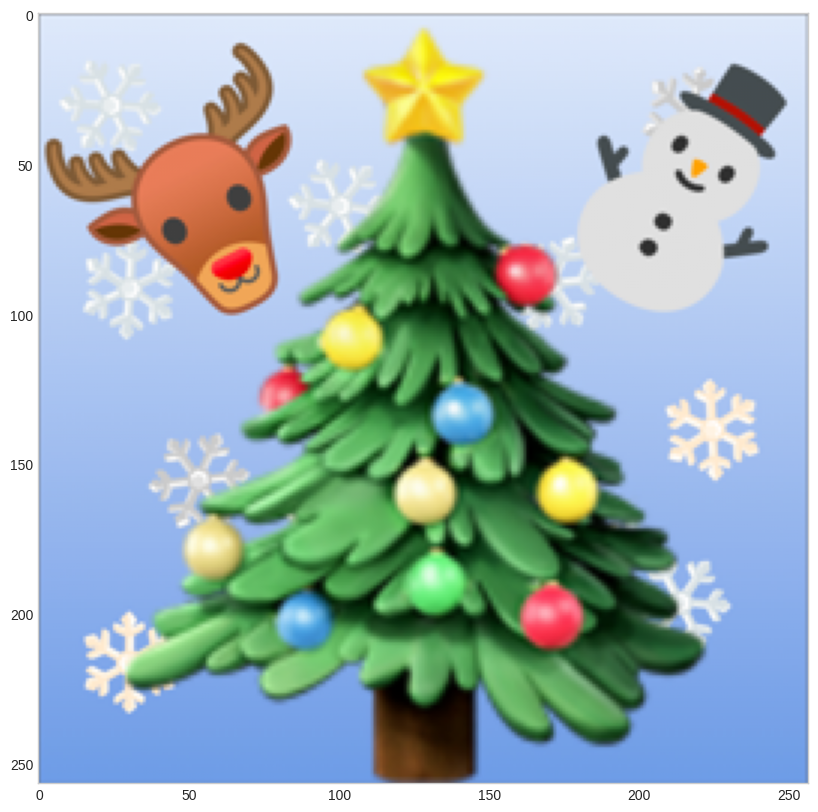

In [7]:
df_img = pd.read_csv('image.csv')
image = df_to_image(df_img)
assert image_to_df(image).equals(df_img) 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.grid(None);

In [187]:
image2=image.copy()
image2[:,128:] = image2[:,128:][:,::-1]
image2[:,:128] = image2[:,:128][:,::-1]

In [188]:
pointsseg1 = opt4(0,128,0,66,127,flag=True)


seg_replace(pointsseg1,flip =True)

<AxesSubplot: >

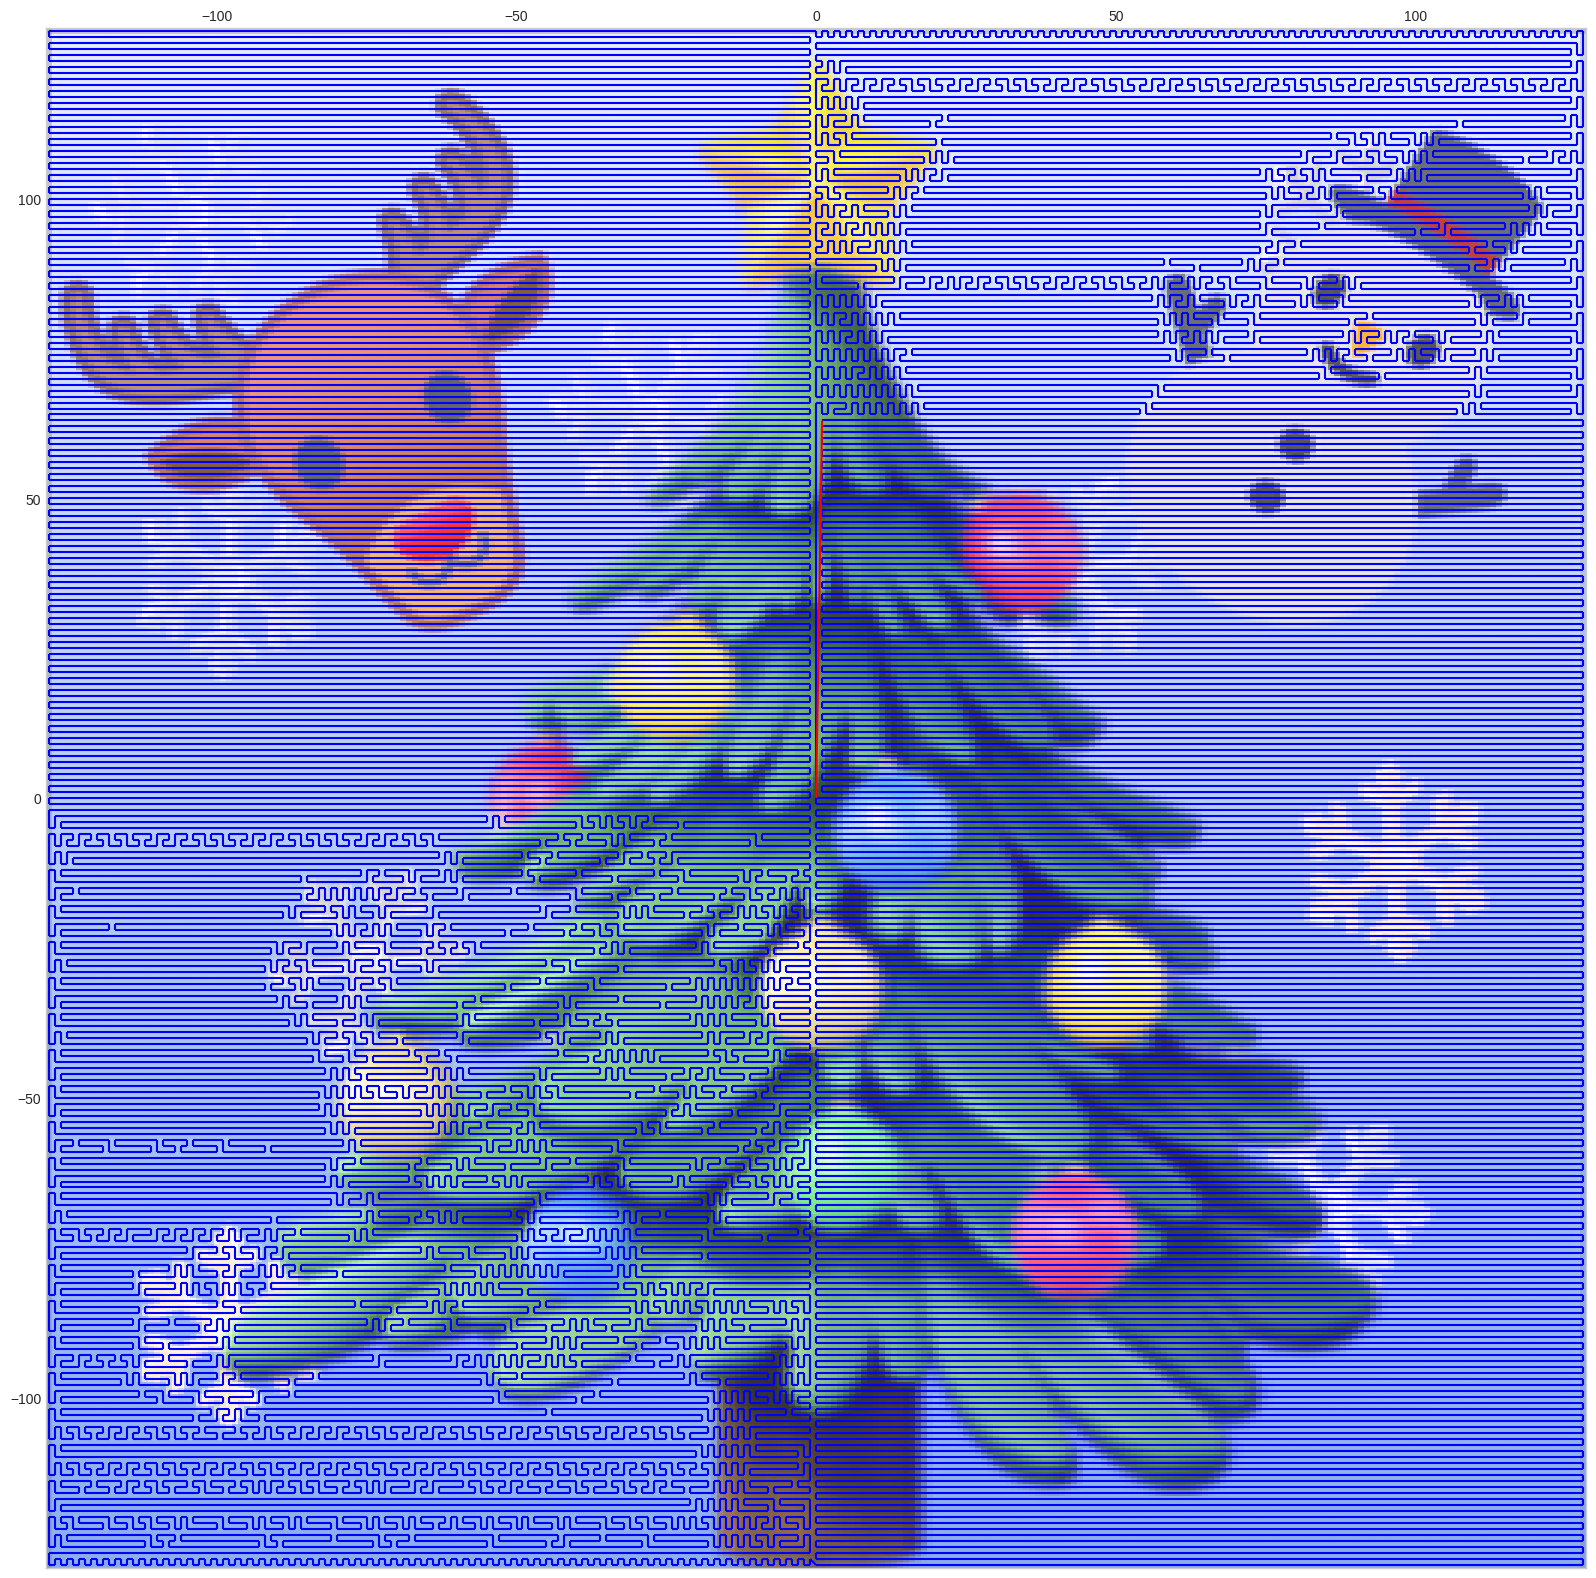

In [189]:
plot_traj(np.array(pointsln),image,figsize=(20,20))

<AxesSubplot: >

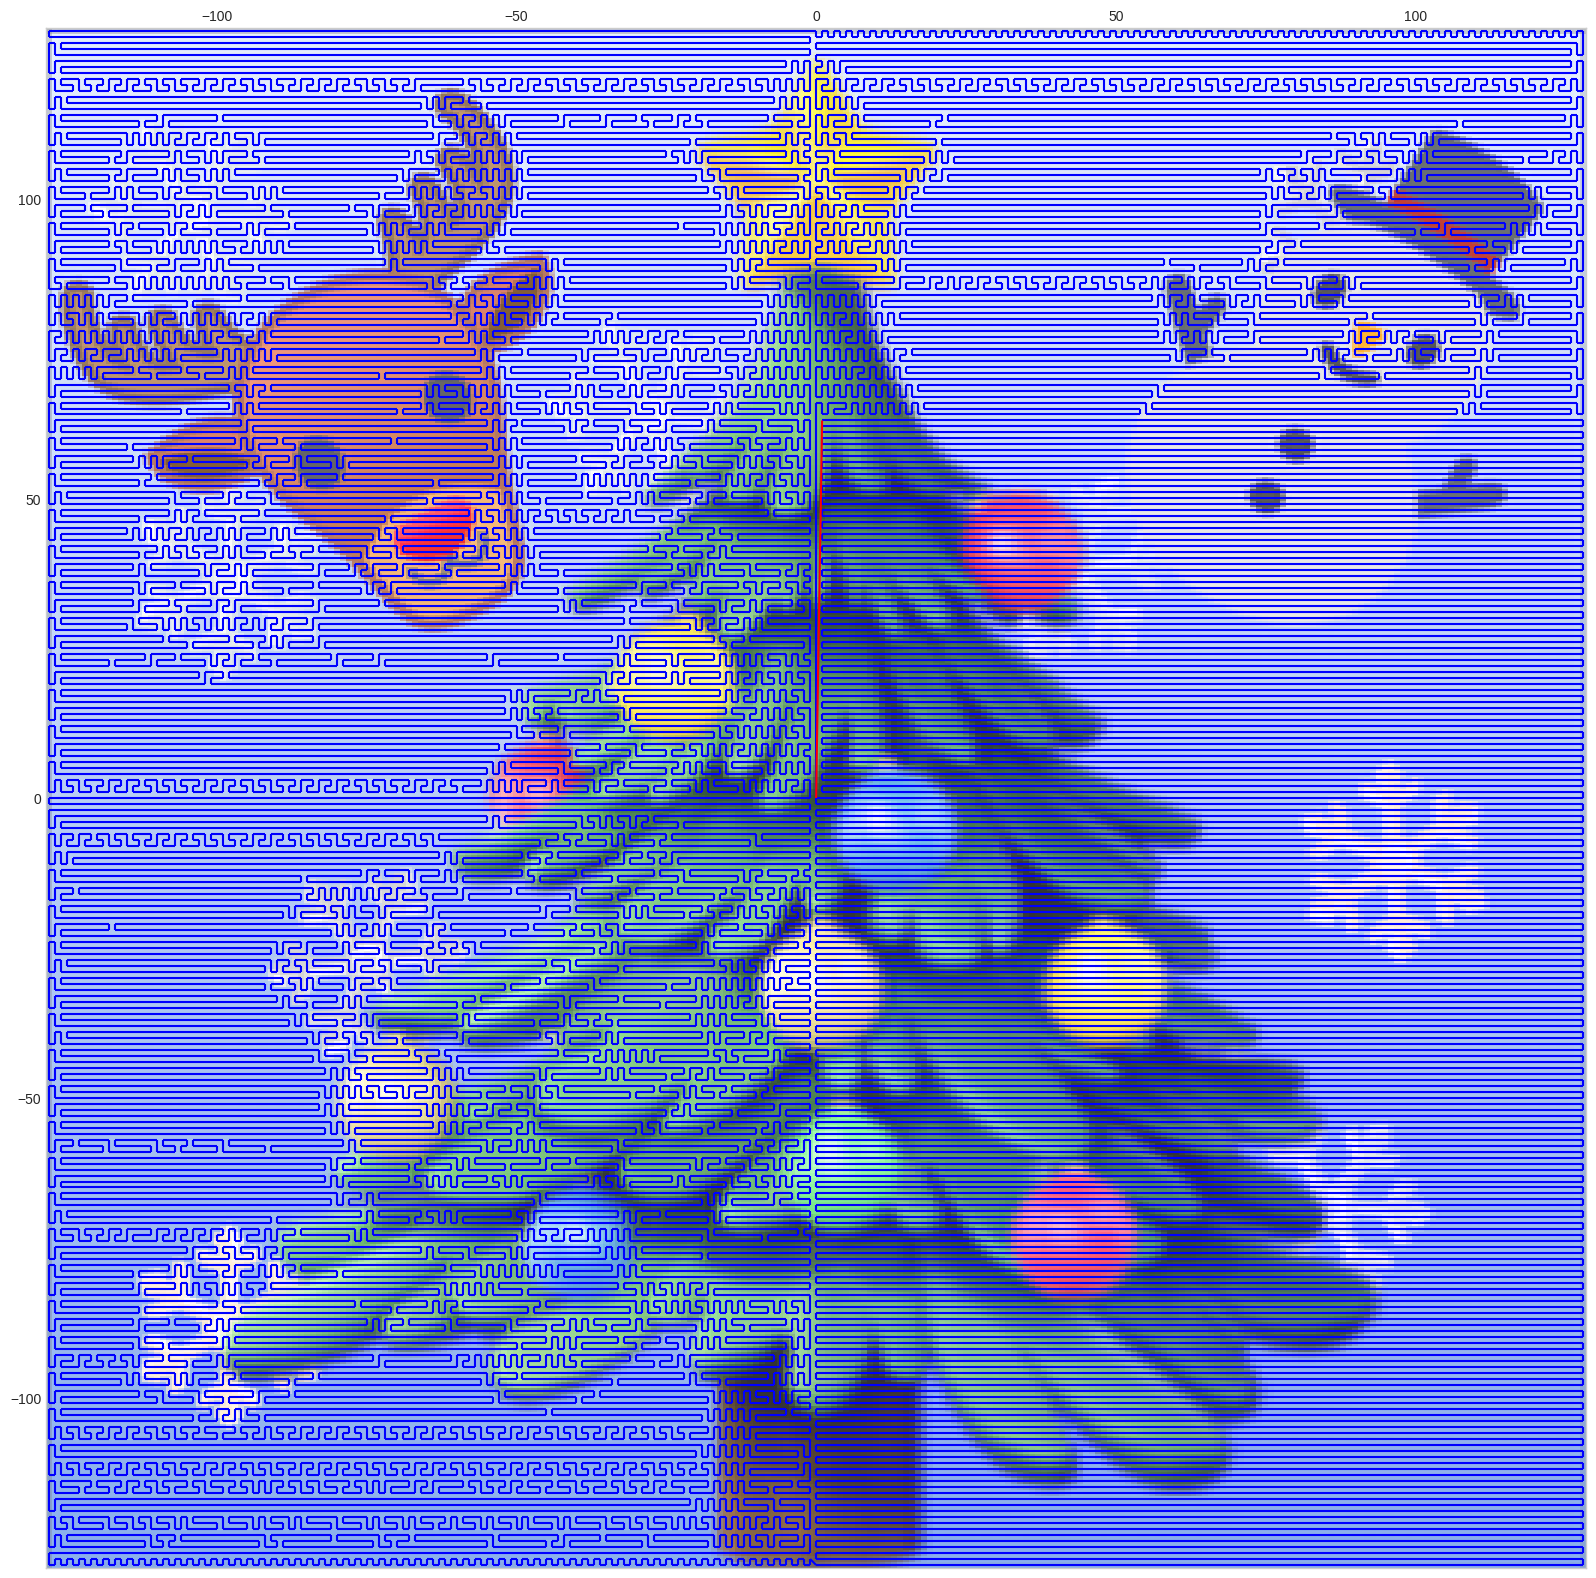

In [190]:
pointsseg2 = opt4(-128,-1,-128,3,127,flag=True)
seg_replace(pointsseg2,flip =False)
plot_traj(np.array(pointsln),image,figsize=(20,20))

<AxesSubplot: >

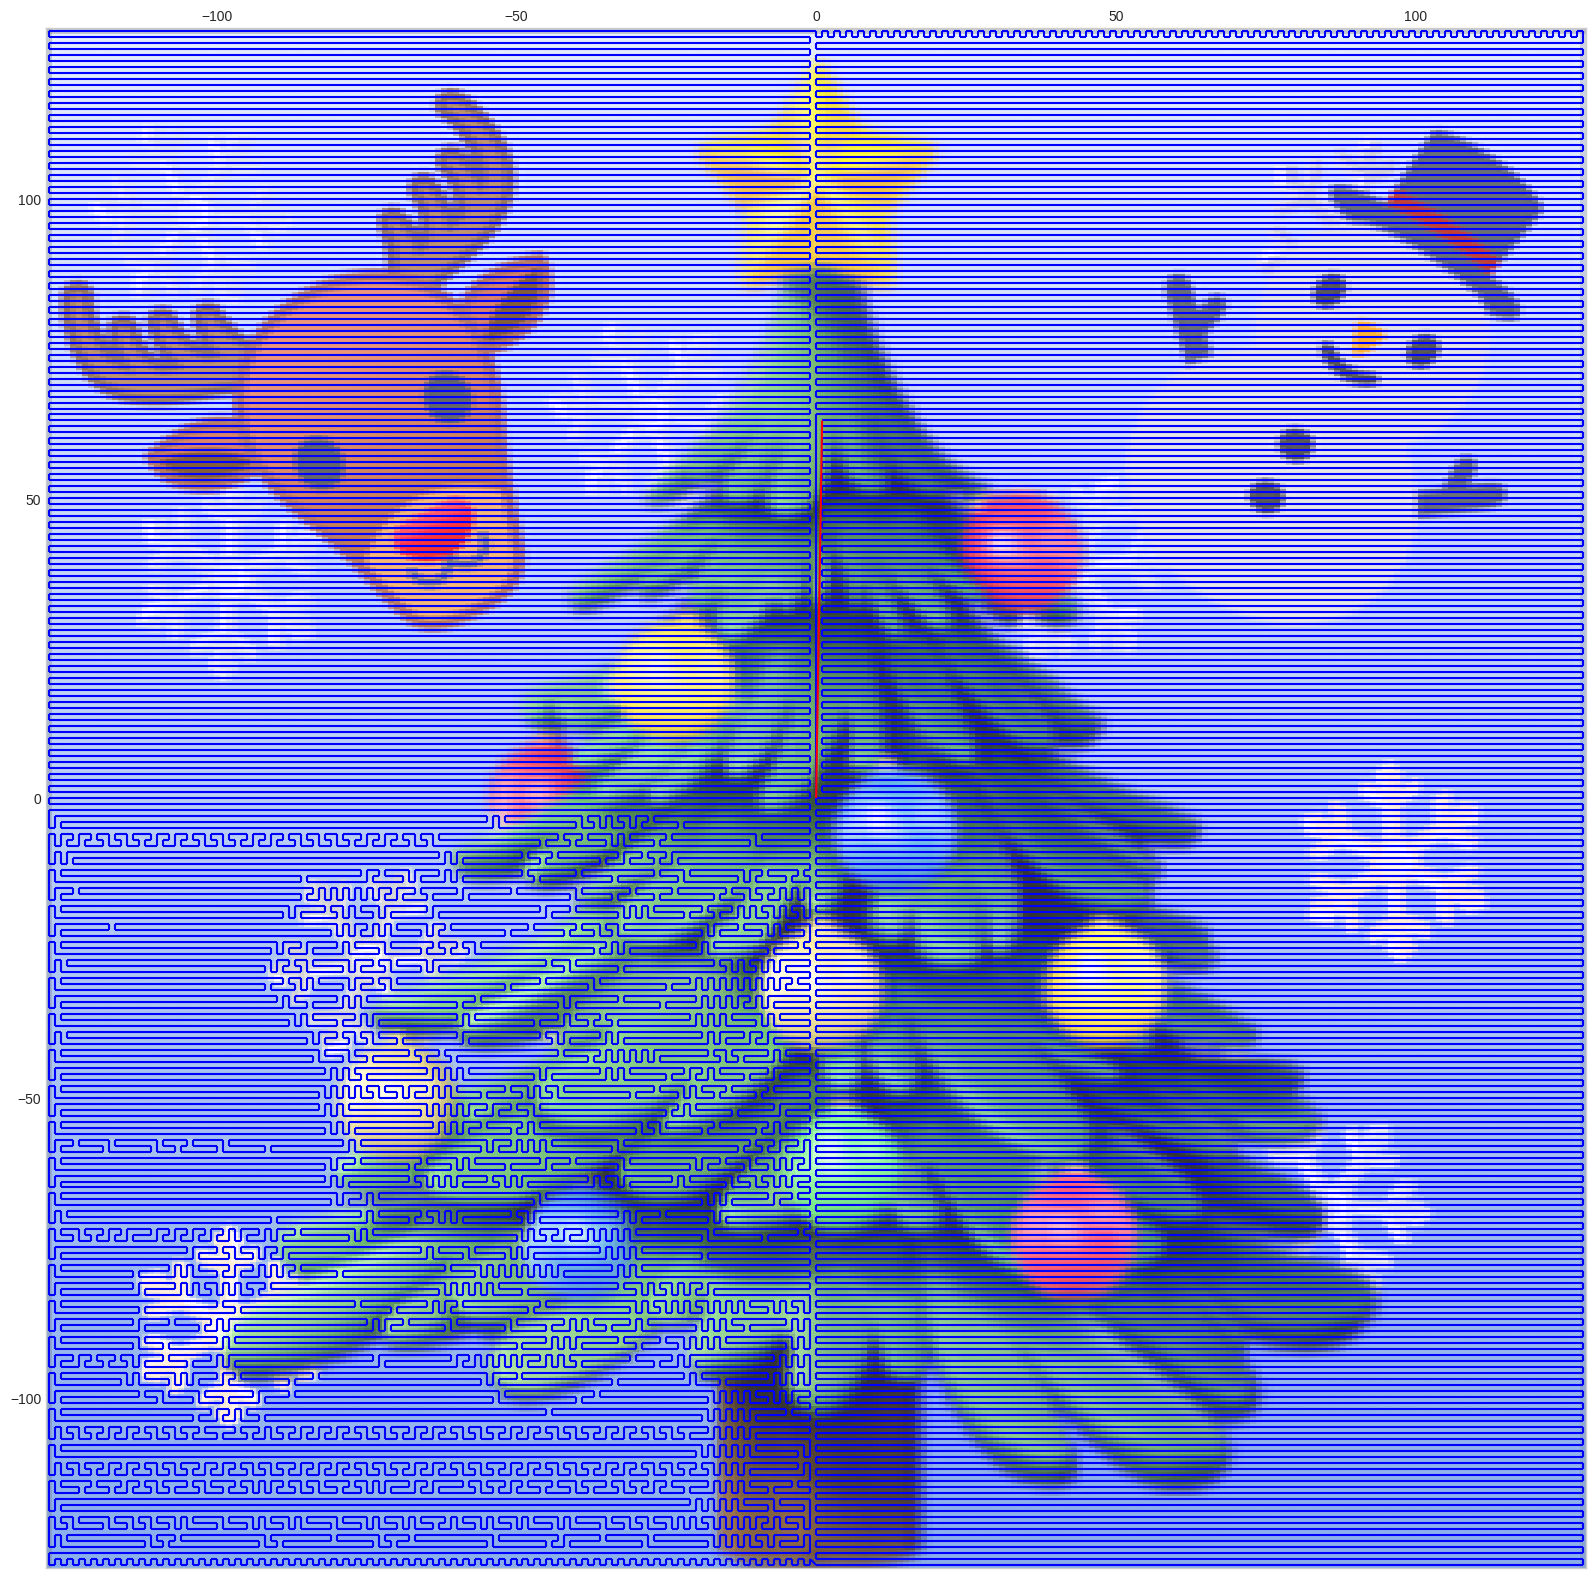

In [186]:
pointsseg5 = opt4(-128,-1,-128,-123,-1,flag=False)
seg_replace(pointsseg5,flip =False)
plot_traj(np.array(pointsln),image,figsize=(20,20))

<AxesSubplot: >

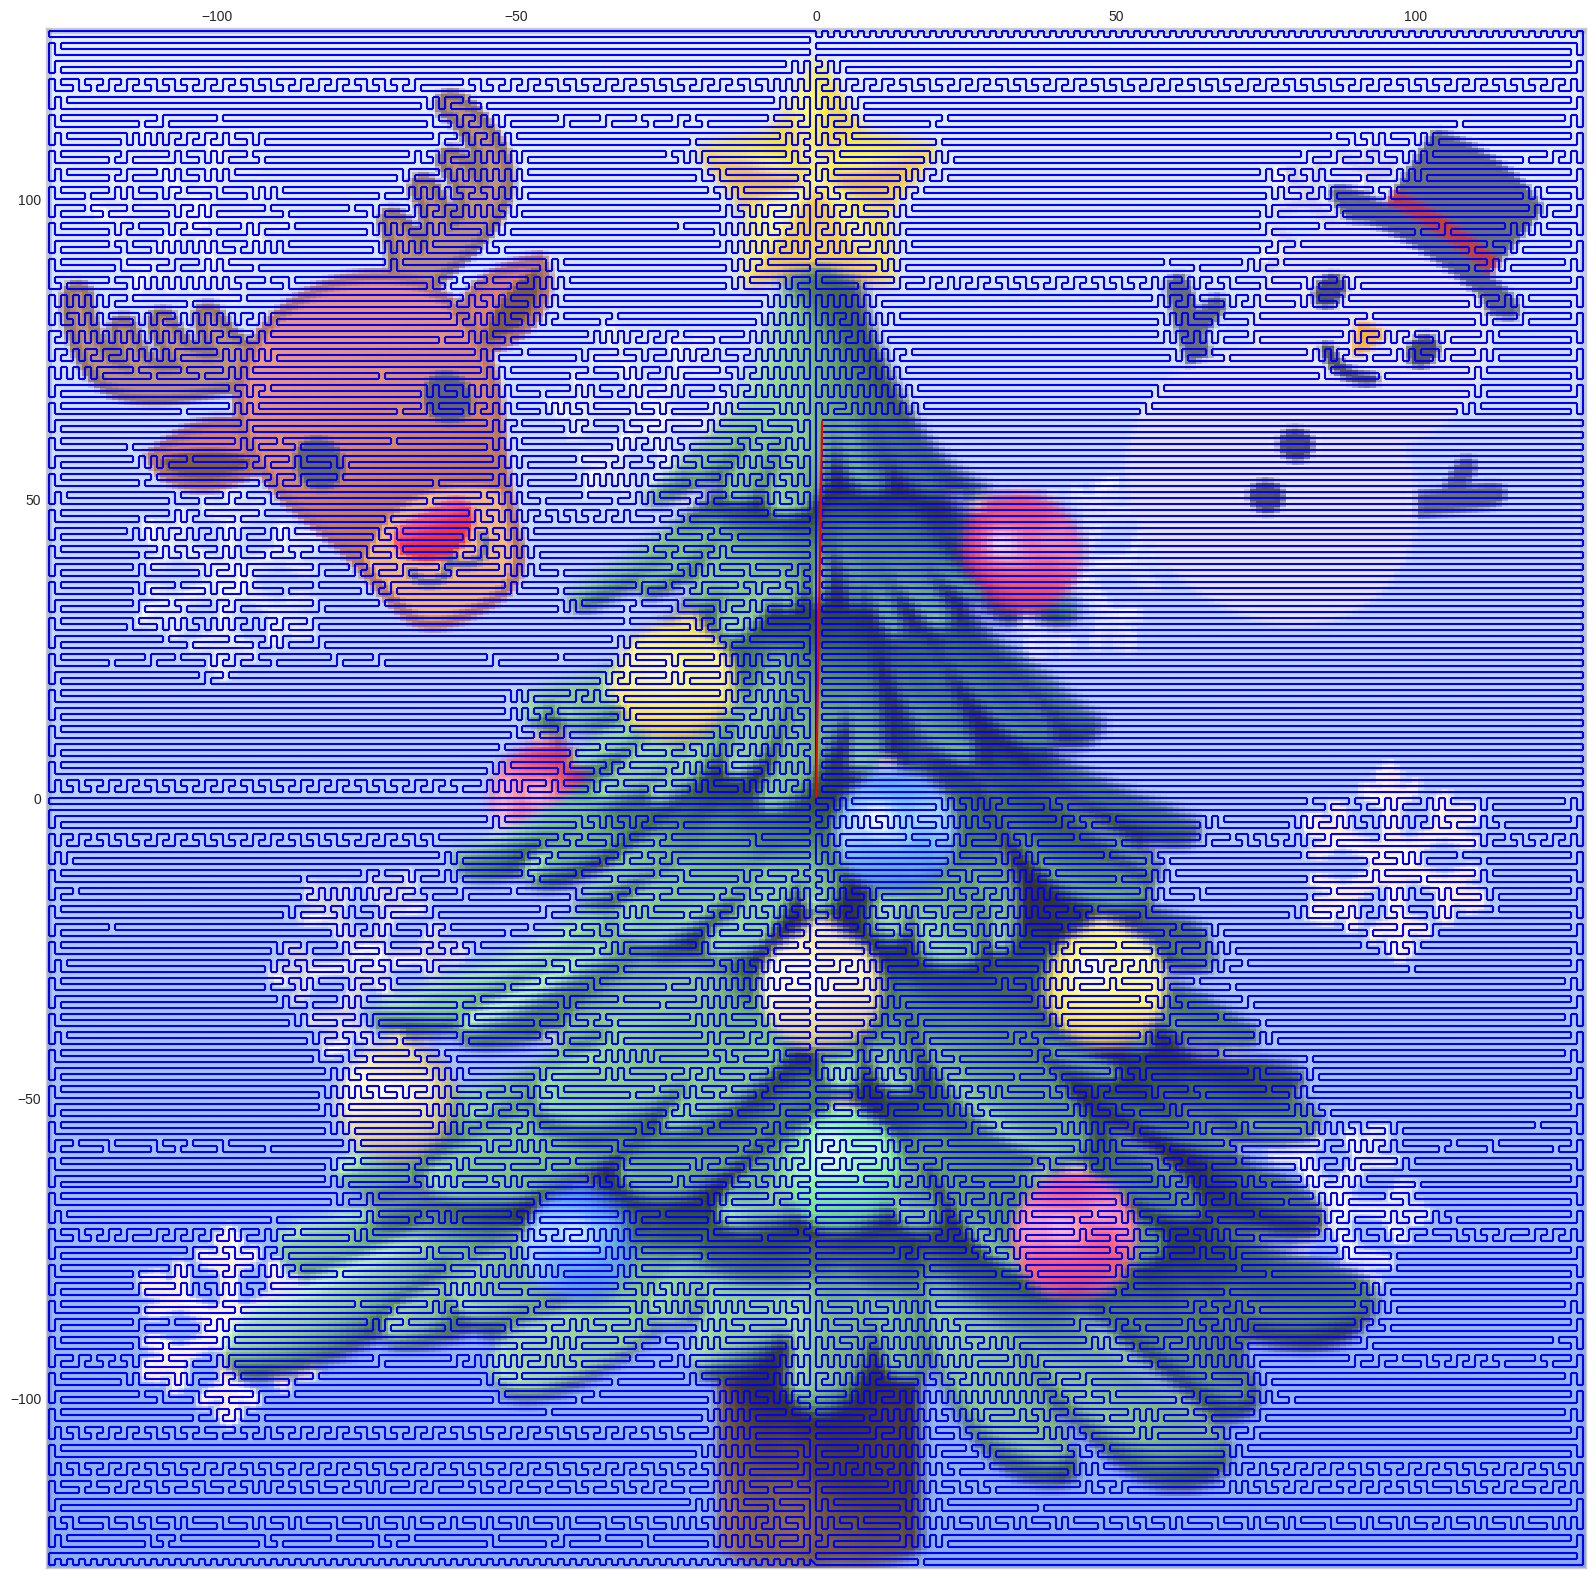

In [191]:
pointsseg3 = opt4(0,128,0,-126,3,flag=True)
seg_replace(pointsseg3,flip =True)
plot_traj(np.array(pointsln),image,figsize=(20,20))

<AxesSubplot: >

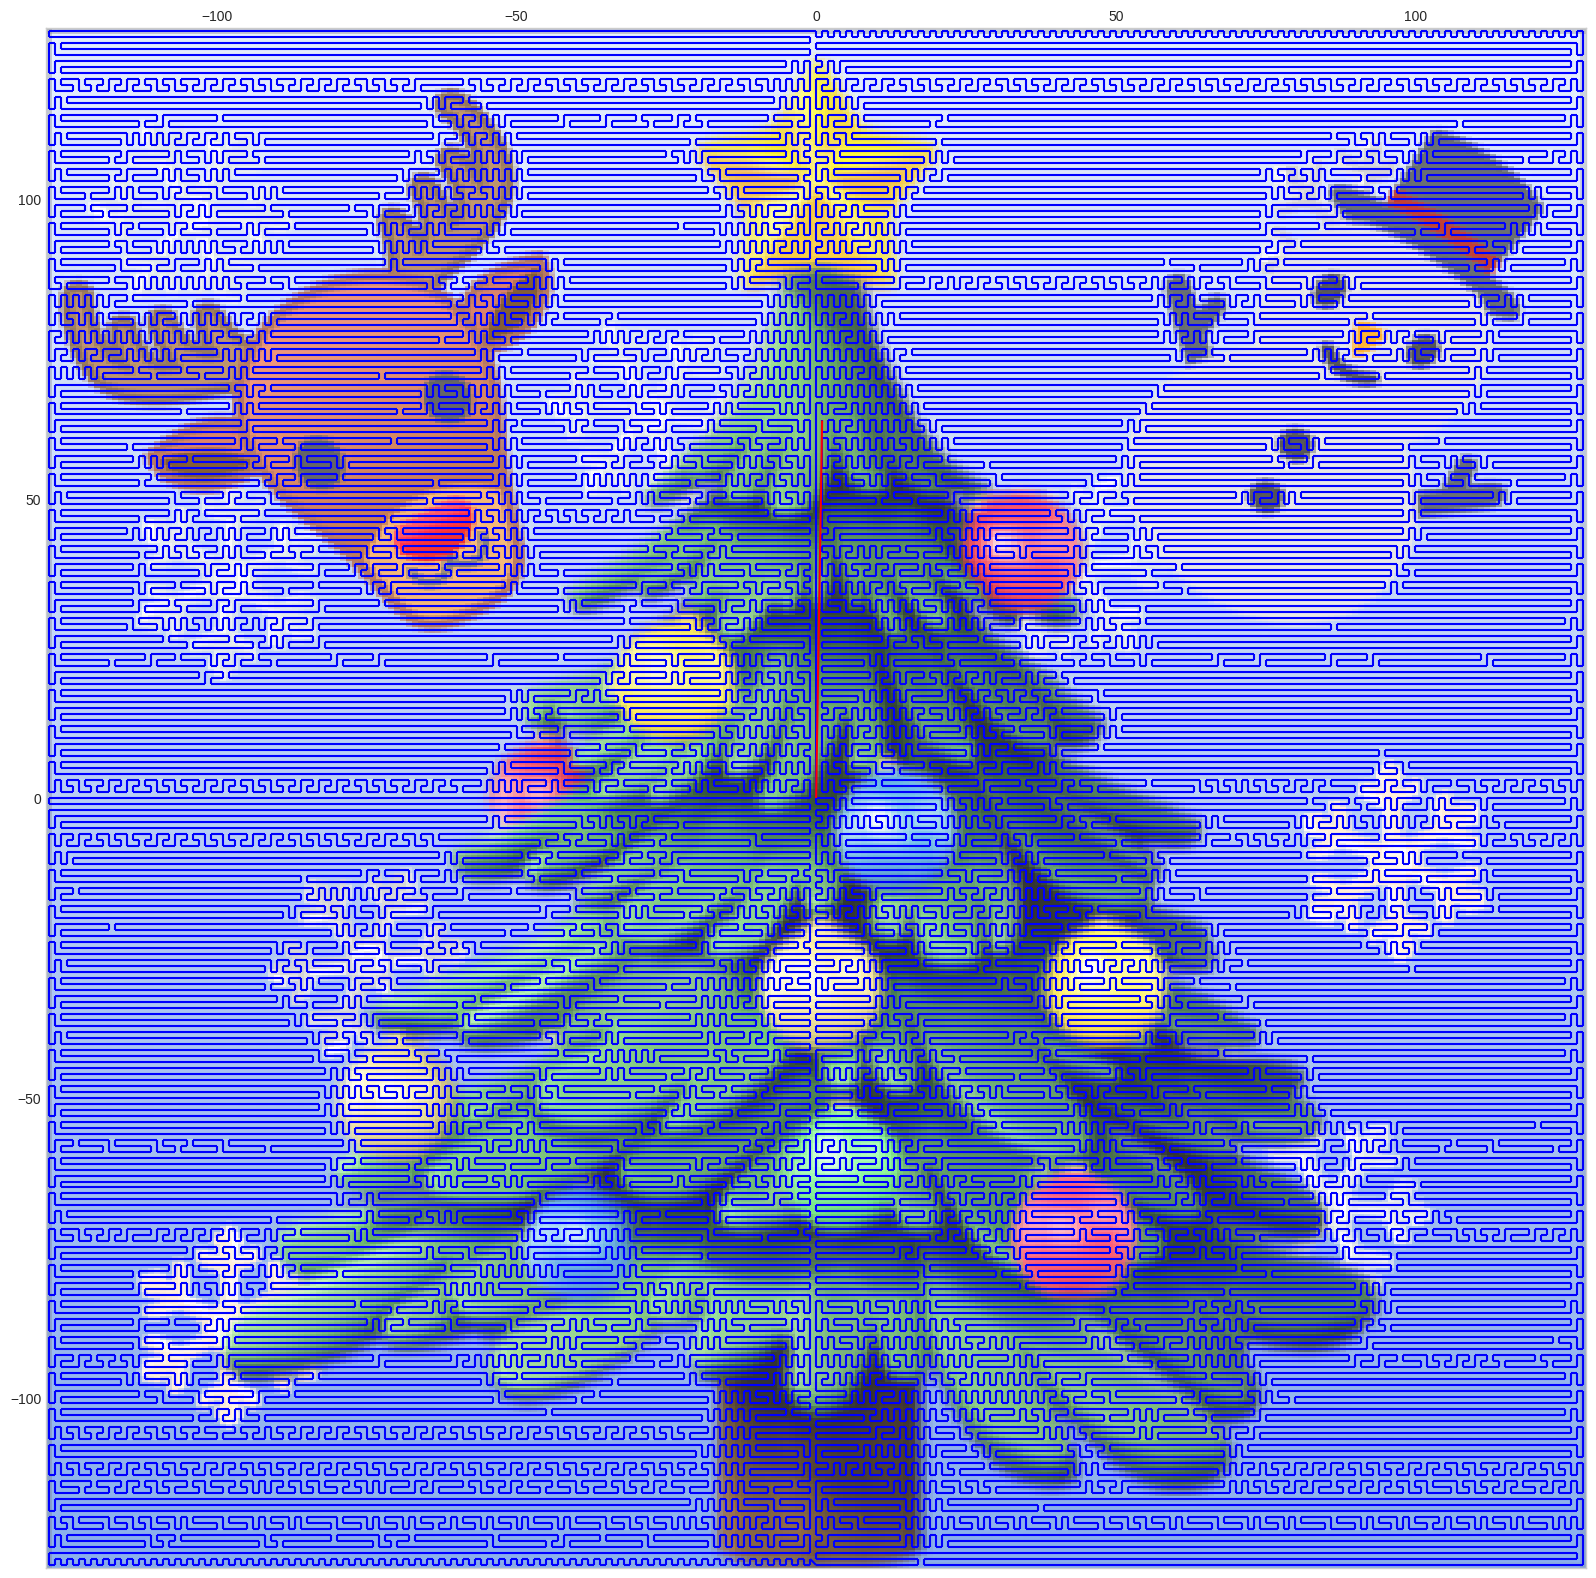

In [192]:
image2 = image.copy()
image2[:,129:]=image2[:,129:][:,::-1]
pointsseg4 = opt4(1,128,1,3,64,flag=False)
seg_replace(pointsseg4,flip =True)
plot_traj(np.array(pointsln),image,figsize=(20,20))

In [206]:
config2=config1.copy()

for pt in pointsln[64:]:
    
    config_new = np.expand_dims(standard_config(*pt),axis=0)
    config2 = np.append(config2,config_new,axis=0)

In [207]:
config2=np.append(config2,get_path_to_configuration(config2[-1],config2[0])[1:],axis=0)

In [205]:
get_path_to_configuration(config2[-1],config2[0])

array([[[ 64,   0],
        [-32,   0],
        [-16,   0],
        [ -8,   0],
        [ -4,   0],
        [ -2,   0],
        [ -1,   0],
        [ -1,   0]]])

In [208]:
total_cost(config2,image)

77248.91051274675

In [209]:
len(config2)

66082

In [210]:
for i in range(1, len(config2)):
    diffs = np.abs(np.asarray(config2[i-1]) - np.asarray(config2[i])).sum(axis=1)

    assert diffs.max() <= 1, f"from config:{config2[i-1]} to config:{config2[i]} i: {i}"
    assert diffs.max()!=0, f"i: {i}"


In [211]:
submission = pd.Series(
    [config_to_string(x) for x in config2],
    name="configuration",
)

submission.head()

0    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 1
2    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 1;-1 1
3    64 0;-32 0;-16 0;-8 0;-4 0;-2 1;-1 1;-1 1
4    64 0;-32 0;-16 0;-8 0;-4 0;-2 2;-1 1;-1 1
Name: configuration, dtype: object

In [212]:
submission.to_csv('submission_best.csv',index=False)